In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pandas as pd
import seaborn as sns

In [2]:
data = {
    "Method": (["MedCLIP"] * 6 + ["BiomedCLIP"] * 6 + ["PLIP"] * 6 + ["CLIP"] * 6 + ["BLIP2"] * 6) * 3,
    "FT": ["ZS"] * 5 * 6 + ["LP"] * 30 + ["LoRA"] * 30,
    "Dataset": ["CheXpert", "GF3300", "PAPILA", "HAM10000", "FairVLMed", "Camelyon17"] * 15,
    "AUC": [
        48.27,
        46.27,
        50.51,
        54.11,
        54.23,
        76.40,
    ]
    + [72.50, 56.65, 78.33, 67.26, 54.33, 75.90]
    + [52.88, 38.66, 65.72, 57.73, 56.63, 74.5]
    + [
        54.05,
        70.64,
        78.25,
        72.05,
        60.19,
        53.00,
    ]
    + [
        63.65,
        42.75,
        69.11,
        44.36,
        43.83,
        51.8,
    ]
    + [
        89.77,
        76.48,
        80.14,
        80.85,
        72.45,
        93.38,
    ]
    + [
        83.60,
        80.34,
        60.05,
        85.80,
        71.32,
        98.43,
    ]
    + [53.18, 79.96, 80.14, 88.52, 71.54, 99.11]
    + [
        76.61,
        80.31,
        88.42,
        84.89,
        68.49,
        95.44,
    ]
    + [
        82.91,
        80.02,
        84.63,
        90.10,
        74.15,
        98.43,
    ]
    + [
        90.44,
        82.28,
        81.80,
        86.39,
        73.69,
        97.63,
    ]
    + [
        84.60,
        81.48,
        92.91,
        88.61,
        73.61,
        99.01,
    ]
    + [52.88, 84.71, 80.36, 86.88, 74.37, 99.91]
    + [
        85.72,
        84.22,
        95.74,
        89.24,
        74.63,
        99.86,
    ]
    + [
        86.55,
        83.08,
        91.13,
        89.18,
        77.84,
        99.94,
    ],
}

In [21]:
general_methods = ["CLIP", "BLIP2", "LLaVA"]
medical_methods = ["MedCLIP", "BiomedCLIP", "PLIP", "LLaVA-Med"]

df_diagnosis = pd.DataFrame.from_dict(data)
df_diagnosis = df_diagnosis.loc[(df_diagnosis["Dataset"].isin(["CheXpert"]) & (df_diagnosis["Method"] != "PLIP"))]

# df_diag_med = df_diagnosis.loc[(df_diagnosis["Method"].isin(
#     medical_methods)) & (df_diagnosis["FT"] == "ZS")]

df_diag_med = df_diagnosis.loc[(df_diagnosis["Method"].isin(medical_methods))]

df_diag_gen = df_diagnosis.loc[(df_diagnosis["Method"].isin(general_methods)) & (df_diagnosis["FT"] != "ZS")]

df_diag_med

,Method,FT,Dataset,AUC
0,MedCLIP,ZS,CheXpert,48.27
6,BiomedCLIP,ZS,CheXpert,72.50
30,MedCLIP,LP,CheXpert,89.77
36,BiomedCLIP,LP,CheXpert,83.60
60,MedCLIP,LoRA,CheXpert,90.44
66,BiomedCLIP,LoRA,CheXpert,84.60


In [22]:
df_diag_gen

,Method,FT,Dataset,AUC
48,CLIP,LP,CheXpert,76.61
54,BLIP2,LP,CheXpert,82.91
78,CLIP,LoRA,CheXpert,85.72
84,BLIP2,LoRA,CheXpert,86.55


In [23]:
efficiency_diag = {
    "Model": ["CLIP", "BLIP2", "MedCLIP", "BiomedCLIP", "PLIP"] * 3,
    "FT": ["LP"] * 5 + ["LoRA"] * 5 + ["ZS"] * 5,
    "param": [513, 1409, 513, 513, 769]
    + [443137, 1758593, 212481, 295425, 443137]
    + [87849729, 985953665, 27913083, 86192385, 87456769],
}

data_num_ft_diag = {
    "CheXpert": 187205,
    "GF3300": 2706,
    "PAPILA": 364,
    "HAM10000": 8137,
}

data_num_pretrain = {"MedCLIP": 570000, "BiomedCLIP": 46000000}

df_param_diag = pd.DataFrame.from_dict(efficiency_diag)

for method in df_diag_med["Method"].tolist():
    for ft in df_diag_med["FT"].tolist():
        if ft == "ZS":
            cost = (
                df_param_diag.loc[(df_param_diag["Model"] == method) & (
                    df_param_diag["FT"] == ft)].iloc[0]["param"]
                * data_num_pretrain[method]
            )
        else:
            cost_pretrain = (
                df_param_diag.loc[(df_param_diag["Model"] == method) & (
                    df_param_diag["FT"] == "ZS")].iloc[0]["param"]
                * data_num_pretrain[method]
            )
            cost_ft = (
                df_param_diag.loc[(df_param_diag["Model"] == method) & (
                    df_param_diag["FT"] == ft)].iloc[0]["param"]
                * data_num_ft_diag["CheXpert"]
            )
        df_diag_med.loc[(df_diag_med["Method"] == method) &
                        (df_diag_med["FT"] == ft), "cost"] = cost
        # print(cost)

for method in df_diag_gen["Method"].tolist():
    for ft in df_diag_gen["FT"].tolist():
        cost = (
            df_param_diag.loc[(df_param_diag["Model"] == method) & (
                df_param_diag["FT"] == ft)].iloc[0]["param"]
            * data_num_ft_diag["CheXpert"]
        )

        df_diag_gen.loc[(df_diag_gen["Method"] == method) &
                        (df_diag_gen["FT"] == ft), "cost"] = cost

df_param_diag

/tmp/ipykernel_2018394/4292192068.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diag_med.loc[(df_diag_med["Method"] == method) & (df_diag_med["FT"] == ft), "cost"] = cost
/tmp/ipykernel_2018394/4292192068.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diag_gen.loc[(df_diag_gen["Method"] == method) & (df_diag_gen["FT"] == ft), "cost"] = cost


,Model,FT,param
0,CLIP,LP,513
1,BLIP2,LP,1409
2,MedCLIP,LP,513
3,BiomedCLIP,LP,513
4,PLIP,LP,769
5,CLIP,LoRA,443137
6,BLIP2,LoRA,1758593
7,MedCLIP,LoRA,212481
8,BiomedCLIP,LoRA,295425
9,PLIP,LoRA,443137


In [24]:
df_diag_med

,Method,FT,Dataset,AUC,cost
0,MedCLIP,ZS,CheXpert,48.27,1.591046e+13
6,BiomedCLIP,ZS,CheXpert,72.50,3.964850e+15
30,MedCLIP,LP,CheXpert,89.77,1.591046e+13
36,BiomedCLIP,LP,CheXpert,83.60,3.964850e+15
60,MedCLIP,LoRA,CheXpert,90.44,1.591046e+13
66,BiomedCLIP,LoRA,CheXpert,84.60,3.964850e+15


In [25]:
df_diag_gen

,Method,FT,Dataset,AUC,cost
48,CLIP,LP,CheXpert,76.61,9.603616e+07
54,BLIP2,LP,CheXpert,82.91,2.637718e+08
78,CLIP,LoRA,CheXpert,85.72,8.295746e+10
84,BLIP2,LoRA,CheXpert,86.55,3.292174e+11


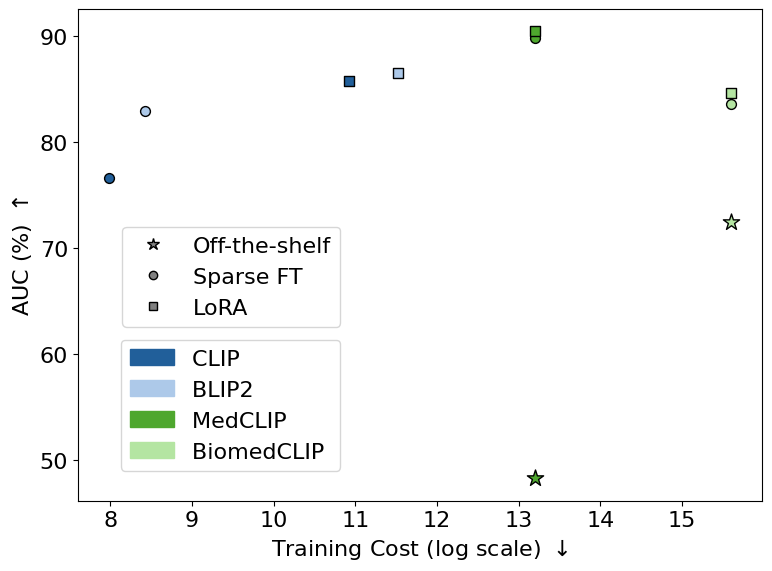

In [93]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.markers as mmark

plt.rcParams["font.serif"] = ["Calibri"]
plt.rcParams["font.size"] = 16

plt.figure(figsize=(8, 6))

# color_gen = "red"
# color_med = "blue"


marker_zs = "*"
marker_lp = "o"
marker_lora = "s"

marker_size_zs = 150
marker_size_lp = 50
marker_size_lora = 50

colors = {"CLIP": "#215f9a", "BLIP2": "#adc9e9", "MedCLIP": "#4ea72e", "BiomedCLIP": "#b4e5a2"}

df_plot = pd.concat([df_diag_gen, df_diag_med]).reset_index(drop=True)

cost_list = []
for i in range(len(df_plot)):
    item = df_plot.iloc[i]
    cost_list.append(item["cost"])


# cost_list_logscale = np.log10(lambda_list)

cost_log_list = []

for i in range(len(df_plot)):
    item = df_plot.iloc[i]

    method = item["Method"]
    ft = item["FT"]
    auc = item["AUC"]
    cost = item["cost"]

    cost_log_list.append(np.log10(cost))

    plt.scatter(
        np.log10(cost),
        auc,
        marker=globals()[f"marker_{ft.lower()}"],
        lw=1,
        s=globals()[f"marker_size_{ft.lower()}"],
        c=colors[method],
        edgecolors="black",
    )

plt.xlabel(r"Training Cost (log scale) $\downarrow$")
plt.ylabel(r"AUC (%) $\uparrow$")

handles = [mpatches.Patch(color=v) for k, v in colors.items()]
leg1 = plt.legend(handles, [x + " " for x in colors.keys()], bbox_to_anchor=(0.4, 0.35))
plt.gca().add_artist(leg1)

handles = [
    mlines.Line2D([], [], marker="*", markersize=9, mec="black", mfc="gray", ls=""),
    mlines.Line2D([], [], marker="o", markersize=6, mec="black", mfc="gray", ls=""),
    mlines.Line2D([], [], marker="s", markersize=6, mec="black", mfc="gray", ls=""),
]
plt.legend(handles, ["Off-the-shelf", "Sparse FT", "LoRA"], bbox_to_anchor=(0.4, 0.58))

plt.tight_layout()

In [31]:
cost_log_list

[np.float64(7.982434809104771),
 np.float64(8.421228437102311),
 np.float64(10.918855457226938),
 np.float64(11.517482784128907),
 np.float64(13.201682662635596),
 np.float64(15.598226729773492),
 np.float64(13.201682662635596),
 np.float64(15.598226729773492),
 np.float64(13.201682662635596),
 np.float64(15.598226729773492)]